In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# basic
import pandas as pd
import numpy as np

# data processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import string

# machine learningg
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.sparse import csr_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [4]:
np.random.seed(1234)

Reading in our labelled train data `train_labelled.csv`

In [5]:
df = pd.read_csv('/content/drive/MyDrive/NUS/BT4222/BT4222 Project/train_labelled.csv').drop(columns=['time', 'name','username','replies_count','retweets_count', 'likes_count' ])
df.head()

,tweet,product,label
0,id rather buy a model thank you,tm3,1
1,a lil surprised the bmw actually won also weir...,tm3,0
2,looking for a steal steering wheel trim for te...,tm3,0
3,tesla model will be europes best selling ev of,tm3,1
4,win a tesla model long range or cash,tm3,0


In [6]:
def process_tweet(tweet):
    #Remove old style retweet text "RT"
    tweet2 = re.sub(r'^RT[\s]','', tweet)
    
    # Remove hyperlinks
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet2)
    
    # Remove hastags
    tweet2 = re.sub(r'#','',tweet2)
    
    # Remove punctuation
    tweet2 = re.sub(r'[,\.!?\'\"]', '', tweet2)
    
    # lowercase
    tweet2 = tweet2.lower()
        
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet2)    
        
    #Import the english stop words list from NLTK
    stopwords_english = stopwords.words('english') 
    
    # Creating a list of words without stopwords
    tweets_clean = []
    for word in tweet_tokens:
      if word not in stopwords_english and word not in string.punctuation:
        tweets_clean.append(word)
        
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Creating a list of stems of words in tweet
    tweets_stem = []
    for word in tweets_clean:
      tweets_stem.append(wordnet_lemmatizer.lemmatize(word))
        
    return tweets_stem

In [7]:
df['tweet_processed'] = df['tweet'].apply(process_tweet)

In [8]:
df

,tweet,product,label,tweet_processed
0,id rather buy a model thank you,tm3,1,"[id, rather, buy, model, thank]"
1,a lil surprised the bmw actually won also weir...,tm3,0,"[lil, surprised, bmw, actually, also, weird, q..."
2,looking for a steal steering wheel trim for te...,tm3,0,"[looking, steal, steering, wheel, trim, tesla,..."
3,tesla model will be europes best selling ev of,tm3,1,"[tesla, model, europe, best, selling, ev]"
4,win a tesla model long range or cash,tm3,0,"[win, tesla, model, long, range, cash]"
...,...,...,...,...
2015,a michigan startup retrofitted a tesla model s...,tms,0,"[michigan, startup, retrofitted, tesla, model,..."
2016,tesla model s plaid gets track mode and carbon...,tms,0,"[tesla, model, plaid, get, track, mode, carbon..."
2017,ive said it before and ill say it again i like...,tms,-1,"[ive, said, ill, say, liked, ford, truck, even..."
2018,tesla model s plaid with active aero spy shots...,tms,0,"[tesla, model, plaid, active, aero, spy, shot,..."


In [9]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [10]:
train_df['tweet_str'] = train_df['tweet_processed'].apply(', '.join)

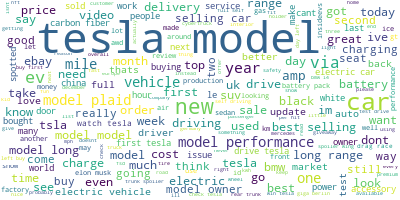

In [ ]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(train_df['tweet_str'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
vectors = []

for index, row in train_df.iterrows():
    vectors.append(", ".join(row[3]))

In [12]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X_dtm = vect.fit_transform(vectors)
X_dtm.shape

(1616, 16971)

In [13]:
y_train = train_df['label'].values

In [14]:
X_test = vect.transform(test_df['tweet'].values)
y_test = test_df['label'].values

In [15]:
# defining the supervised learning classifiers
state = 2022
sgd_classifier = SGDClassifier(random_state=state)
log_classifier = LogisticRegression(multi_class='multinomial', random_state=state, max_iter=1000)
NB_classifier = MultinomialNB()
DT_classifier = DecisionTreeClassifier(random_state=state)
RF_classifier = RandomForestClassifier(random_state=state)
GB_classifier = GradientBoostingClassifier(random_state=state)

In [16]:
def train_and_show_scores(X, y, title, clf): # title = name of classifier
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=2022, stratify=y)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [17]:
# Randomised search cross validatiojn
def rscv(X_train, y_train, clf, distributions): # define the distributions individually for each classifier
  random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
  )
  random_search_cv.fit(X_train, y_train)
  print(f'Best params: {random_search_cv.best_params_}')
  print(f'Best score: {random_search_cv.best_score_}')
  return random_search_cv

In [18]:
def res(clf):
  y_pred = clf.predict(X_test)
  report = """
  The evaluation report is:
  Confusion Matrix:
  {}
  Accuracy: {}
  """.format(confusion_matrix(y_test, y_pred),
            accuracy_score(y_test, y_pred))
  print(report)

## SGD

In [19]:
train_and_show_scores(X_dtm, y_train, 'SGD Classifier', sgd_classifier)

SGD Classifier
Train score: 1.0 ; Validation score: 0.64



In [20]:
# phase 1: learning & loss params
distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)
random_search_cv = rscv(X_dtm, y_train, sgd_classifier, distributions)

Best params: {'eta0': 0.0076009122424709995, 'learning_rate': 'adaptive', 'loss': 'squared_hinge'}
Best score: 0.6670756411726484


In [21]:
# phase 2: penalty
sgd_classifier = random_search_cv.best_estimator_
distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4)
)
random_search_cv = rscv(X_dtm, y_train, sgd_classifier, distributions)

Best params: {'alpha': 9.199308711460112e-05, 'penalty': 'elasticnet'}
Best score: 0.6689332263119673


In [22]:
sgd_classifier = random_search_cv.best_estimator_

In [23]:
res(sgd_classifier)


  The evaluation report is:
  Confusion Matrix:
  [[ 13  20   6]
 [  4 226  30]
 [  4  40  61]]
  Accuracy: 0.7425742574257426
  


## Logistic Regression

In [ ]:
train_and_show_scores(X_dtm, y_train, 'Logistic Classifier', log_classifier)

Logistic Classifier
Train score: 0.86 ; Validation score: 0.63



In [ ]:
distributions = dict(
    solver=['lbfgs', 'sag', 'saga'],
    fit_intercept=[True,False],
    tol=[1e-2, 1e-3, 1e-4, 1e-5],
    C=[0.1, 1, 10]
)
random_search_cv = rscv(X_dtm, y_train, log_classifier, distributions)

Best params: {'tol': 0.001, 'solver': 'saga', 'fit_intercept': True, 'C': 10}
Best score: 0.6615028857546916


In [ ]:
log_classifier = random_search_cv.best_estimator_

In [ ]:
res(log_classifier)


  The evaluation report is:
  Confusion Matrix:
  [[ 12  23   4]
 [  3 228  29]
 [  2  46  57]]
  Accuracy: 0.7351485148514851
  


## Naive Bayes

In [ ]:
train_and_show_scores(X_dtm, y_train, 'Naive Bayes Classifier', NB_classifier)

Naive Bayes Classifier
Train score: 0.8 ; Validation score: 0.61



In [ ]:
distributions = dict(
    alpha=uniform(loc=1e-6, scale=1e-4),
    fit_prior=[True,False]
)
random_search_cv = rscv(X_dtm, y_train, NB_classifier, distributions)

Best params: {'alpha': 1.0581859348820044e-05, 'fit_prior': True}
Best score: 0.6200531284638611


In [ ]:
NB_classifier = random_search_cv.best_estimator_

In [ ]:
res(NB_classifier)


  The evaluation report is:
  Confusion Matrix:
  [[ 16  19   4]
 [  9 209  42]
 [  6  28  71]]
  Accuracy: 0.7326732673267327
  


## Decision Tree

In [ ]:
train_and_show_scores(X_dtm, y_train, 'Decision Tree Classifier', DT_classifier)

Decision Tree Classifier
Train score: 1.0 ; Validation score: 0.57



In [ ]:
distributions = dict(
    criterion=['gini', 'entropy'],
    max_features=['auto', 'sqrt', 'log2'],
    ccp_alpha=uniform(loc=1e-6, scale=1e-4)
)
random_search_cv = rscv(X_dtm, y_train, DT_classifier, distributions)

Best params: {'ccp_alpha': 1.6164599746371855e-05, 'criterion': 'entropy', 'max_features': 'sqrt'}
Best score: 0.6027099338760846


In [ ]:
DT_classifier = random_search_cv.best_estimator_

In [ ]:
res(DT_classifier)


  The evaluation report is:
  Confusion Matrix:
  [[ 10  22   7]
 [ 11 204  45]
 [  3  51  51]]
  Accuracy: 0.655940594059406
  


## Random Forest

In [ ]:
train_and_show_scores(X_dtm, y_train, 'Random Forest Classifier', RF_classifier)

Random Forest Classifier
Train score: 1.0 ; Validation score: 0.62



In [ ]:
distributions = dict(
    criterion=['gini', 'entropy'],
    max_features=['auto', 'sqrt', 'log2'],
    ccp_alpha=uniform(loc=1e-6, scale=1e-4),
    bootstrap=[True,False]
)
random_search_cv = rscv(X_dtm, y_train, RF_classifier, distributions)

Best params: {'bootstrap': False, 'ccp_alpha': 6.965002838980942e-05, 'criterion': 'gini', 'max_features': 'sqrt'}
Best score: 0.6503688414937124


In [ ]:
RF_classifier = random_search_cv.best_estimator_

In [ ]:
res(RF_classifier)


  The evaluation report is:
  Confusion Matrix:
  [[  9  21   9]
 [  0 232  28]
 [  0  52  53]]
  Accuracy: 0.7277227722772277
  


## Gradient Boosting

In [ ]:
train_and_show_scores(X_dtm, y_train, 'Gradient Boosting Classifier', GB_classifier)

Gradient Boosting Classifier
Train score: 0.82 ; Validation score: 0.64



In [ ]:
distributions = dict(
    learning_rate=[0.001, 0.01, 0.1, 0.5],
    max_features=['auto', 'sqrt', 'log2'],
    ccp_alpha=uniform(loc=1e-6, scale=1e-4),
    max_depth=[2]
)
random_search_cv = rscv(X_dtm, y_train, GB_classifier, distributions)

Best params: {'ccp_alpha': 1.3852469489502273e-05, 'learning_rate': 0.5, 'max_depth': 2, 'max_features': 'auto'}
Best score: 0.6361388220005351


In [ ]:
GB_classifier = random_search_cv.best_estimator_

In [ ]:
res(GB_classifier)


  The evaluation report is:
  Confusion Matrix:
  [[ 10  22   7]
 [ 12 207  41]
 [  3  56  46]]
  Accuracy: 0.650990099009901
  


## Vader (unsupervised ML)

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
df['compound'] = df['tweet'].apply(lambda review: sid.polarity_scores(review)).apply(lambda score_dict: score_dict['compound'])
# get predicted sentiment based on the words only (the preprocessing must be finetuned to achieve high accuracy)
df['comp_score'] = df['compound'].apply(lambda c: 1 if c >=0.5 else (-1 if c<=-0.5 else 0))

In [ ]:
# check accuracy against actual sentiment 
accuracy_score(df['comp_score'], df['label'])

0.6188118811881188

## Best Model: Stochastic Gradient Descent Classifier
Test with unlabelled data `test.csv`

In [57]:
df_unlabelled = pd.read_csv('/content/drive/MyDrive/NUS/BT4222/BT4222 Project/test.csv').drop(columns=['username','time', 'replies_count','retweets_count','likes_count'])

In [60]:
df_unlabelled['tweet_processed'] = df_unlabelled['tweet'].apply(process_tweet)
df_unlabelled.head()

,tweet,product,tweet_processed
0,hey californians if you want a model you may b...,tm3,"[hey, californian, want, model, may, luck, ser..."
1,fits tesla model front bumper lip spoiler unpa...,tm3,"[fit, tesla, model, front, bumper, lip, spoile..."
2,tried to book a model sr on for my trip to co ...,tm3,"[tried, book, model, sr, trip, co, julythe, ho..."
3,awesome now i can take my model performance to,tm3,"[awesome, take, model, performance]"
4,k is old new rumor is that its k just rumors b...,tm3,"[k, old, new, rumor, k, rumor, dont, doubt, k,..."


In [61]:
tvectors = []

for index, row in df_unlabelled.iterrows():
    tvectors.append(", ".join(row[2]))

In [62]:
test_unlabelled = vect.transform(tvectors)

In [63]:
df_unlabelled['sentiment'] = sgd_classifier.predict(test_unlabelled)
results = df_unlabelled.groupby(['product', 'sentiment']).count().reset_index()
results = results.pivot(index='product', columns='sentiment', values='tweet').reset_index()
results.set_index('product', inplace=True)
results.rename(index={'tm3': 'Model 3', 'tms': 'Model S', 'tmx': 'Model X', 'tmy':'Model Y'}, inplace=True)
results.drop(columns=0, inplace=True)
display(results)

sentiment,-1,1
product,,
Model 3,78,564
Model S,11,46
Model X,60,354
Model Y,80,418


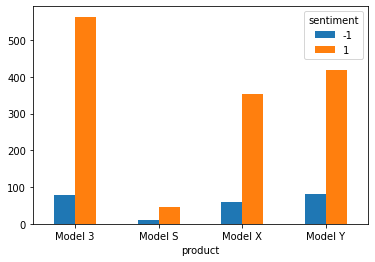

In [64]:
results.plot.bar(rot=0)